In [1]:
# import stuff
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from uncertainty_motion_prediction.dataloader import Dataloader
from uncertainty_motion_prediction.evaluators import DistanceErrorEvaluator
from uncertainty_motion_prediction.predictor import (
    HMMMultinomialFirstOrder, HMMLatentSegmentsExtractor, KMeansOutcome, HMMLatentSegmentsPredictor
)
from uncertainty_motion_prediction.visualizer import SamplingVisualizer, visualize_covariance_to_axis
from uncertainty_motion_prediction.predictor.hmm_latent_segments import (
    segmentize_trajectory, normalise_segment, normalise_segment_batch
)

# pick from 0, 1, 2, 3, 4, all
dataset_suffix = "all"

## As numpy array

In [2]:
dataset=Dataloader();
traj_dataset = dataset.load(0)
trajlets = traj_dataset.get_trajlets(length=4.8, to_numpy=True)
trajlets[0, :, :]

array([[13.017548  ,  5.7825914 , -2.3244442 , -0.07660594, 53.6       ],
       [12.08777   ,  5.751949  , -1.5890517 , -0.06597106, 54.        ],
       [11.746306  ,  5.7298146 , -1.1407656 ,  0.10537256, 54.4       ],
       [11.175158  ,  5.8362471 , -1.6400209 ,  0.17923528, 54.8       ],
       [10.43429   ,  5.8732028 , -1.4061292 ,  0.41904965, 55.2       ],
       [10.050254  ,  6.1714868 , -1.0787423 ,  0.45518986, 55.6       ],
       [ 9.5712958 ,  6.2373547 , -1.207725  ,  0.11543663, 56.        ],
       [ 9.0840742 ,  6.2638361 , -1.2731811 ,  0.17084078, 56.4       ],
       [ 8.5527509 ,  6.3740273 , -1.2327335 ,  0.2715015 , 56.8       ],
       [ 8.0978874 ,  6.4810373 , -1.1467297 ,  0.21789191, 57.2       ],
       [ 7.6353672 ,  6.5483408 , -1.1634956 ,  0.16930578, 57.6       ],
       [ 7.1670909 ,  6.616482  , -1.1264929 ,  0.11639996, 58.        ]])

# Hidden Markov Model with trajectory sub-segment latent states

This method works by modelling a pedestrian trajectory as being composed of multiple common segment primitives. Developing the HMM model consists of 2 parts:
* Extracting common trajectory sub-segments from data. These sub-segments or segment primitives will be the states of the HMM.
* Learn the transition matrix of the HMM. To predict the pedestrian's trajectory, we need the ability to predict the next state or segment primitive the pedestrian will transit to after the current segment the pedestrian is executing.

## Sanity checks

We perform some sanity checks on artificial data first to validate the HMM algorithm. Generate the artificial trajectories from a set of 5 different trajectory types

In [3]:
seg_type1 = [[0, 0, 1, 0], [1, 0, 5, 0], [6, 0, 5, 0]]
seg_type2 = [[0, 0, 1, 0], [1, 0, 1, 0], [2, 0, 1, 0]]
seg_type3 = [[0, 0, 1, 0], [1, 0, 1, 1], [2, 1, 1, 1]]
seg_type4 = [[0, 0, 1, 0], [1, 0, 1, -1], [2, -1, 1, -1]]
seg_type5 = [[0, 0, 1, 0], [1, 0, -2, 0], [-1, 0, -2, 0]]

seg_types = np.array([seg_type1, seg_type2, seg_type3, seg_type4, seg_type5])
test_trajs = []

for seg_type in seg_types:
    for i in range(3):
        angle = np.random.uniform(-2*np.pi, 2*np.pi)
        scale = np.random.uniform(0.5, 1.5)
        trans = np.array([[np.random.uniform(-10, 10), np.random.uniform(-10, 10)]]).T

        R = np.array([[np.cos(angle), -np.sin(angle)],
                      [np.sin(angle), np.cos(angle)]])
        S = np.array([[scale, 0], 
                      [0, scale]])

        seg = np.dot(S, np.dot(R, seg_type[:, 0:2].T))
        seg = seg + trans
        seg_vels = np.dot(S, np.dot(R, seg_type[:, 2:].T))
        sample = np.hstack((seg.T, seg_vels.T))
        test_trajs.append(sample)
        
# print(test_trajs)
print(np.array(test_trajs).shape)

(15, 3, 4)


Test the performance of the clustering step. The code implements 2 different ways to do this: 1) X-means which automatically selects the optimal number of clusters using Bayesian Information Criterion, 2) iterative K-means over a range of possible numbers of clusters, with the user left to select the optimal number of clusters manually from the extracted distance-to-centroid and silhouette methods.

We test (2), since the X-means approach with BIC seems prone to over-clustering.

Text(0.5, 1.0, 'Silhouette scores')

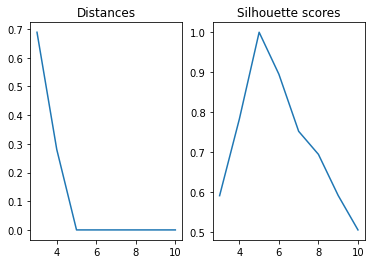

In [4]:
extractor = HMMLatentSegmentsExtractor(segment_len=3)

dists, silhouettes, clusters, centres = extractor.learn_latent_segments_manual_kmeans(np.array(test_trajs))
cluster_range = range(extractor._n_min_centres, extractor._n_max_centres + 1)

fig, axs = plt.subplots(1, 2)
axs[0].plot(cluster_range, dists)
axs[1].plot(cluster_range, silhouettes)
axs[0].set_title('Distances')
axs[1].set_title('Silhouette scores')

In [5]:
clustering_tmp = KMeansOutcome(3, centres[2])
clustering_tmp.save_to_file("./tmp_clustering.pickle")
clustering = KMeansOutcome.load_from_file("./tmp_clustering.pickle")
print(clustering.N)
clustering.classify_batch(test_trajs)

5


[0, 0, 0, 2, 2, 2, 4, 4, 4, 3, 3, 3, 1, 1, 1]

In [6]:
np.array(centres[2]).reshape([2, -1]).T

array([[ 0.00000000e+00,  0.00000000e+00],
       [ 1.09611797e-01,  8.51040000e-17],
       [ 6.57670781e-01,  1.85037171e-17],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 2.90835451e-18,  3.53553391e-01],
       [-2.77555756e-17,  7.07106781e-01],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 1.93712943e-01, -2.49004619e-17],
       [-1.93712943e-01, -3.53553391e-01],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 2.85280703e-17,  3.53553391e-01],
       [-3.70074342e-17,  7.07106781e-01],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 5.00000000e-01, -1.49510468e-17],
       [ 1.00000000e+00,  3.53553391e-01]])

## Learn segments from data

In [2]:
segment_length = 4
estimate_velocity = True
with open(f"./data/train_{dataset_suffix}.pickle", "rb") as _file:
    traj_dataset = pickle.load(_file)
trajlets_for_segments_learning = traj_dataset.get_trajlets(length=segment_length*0.4, overlap=1, to_numpy=True)
print(trajlets_for_segments_learning.shape)

(10497, 4, 5)


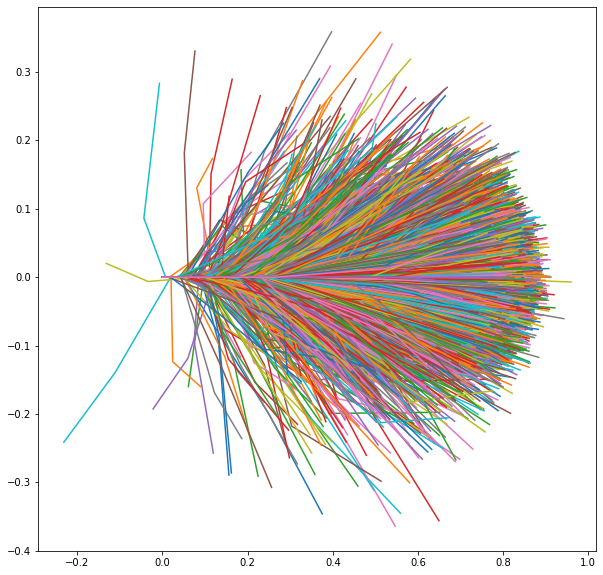

In [3]:
trajlets_for_segments_learning_normalized = normalise_segment_batch(
    trajlets_for_segments_learning, segment_length, estimate_vel=True
)
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
for p in trajlets_for_segments_learning_normalized:
    axs.plot(p[0:segment_length], p[segment_length:])

In [7]:
# Fixed to be 80
extractor = HMMLatentSegmentsExtractor(
    segment_len=segment_length, n_min_centres=20, n_max_centres=200, estimate_velocity=estimate_velocity
)
dists, silhouettes, clusters, centres = extractor.learn_latent_segments_manual_kmeans(
    trajlets_for_segments_learning[:, :, 0:4]
)
cluster_range = range(extractor._n_min_centres, extractor._n_max_centres + 1)

Text(0.5, 1.0, 'Silhouette scores')

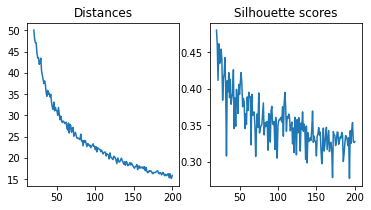

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].plot(cluster_range, dists)
axs[1].plot(cluster_range, silhouettes)
axs[0].set_title('Distances')
axs[1].set_title('Silhouette scores')

In [14]:
fig.savefig('distance-silhoutte.pdf')

In [60]:
center_idx = 0
print(dists[center_idx])
center = np.array(centres[center_idx])
clustering = KMeansOutcome(segment_length, center, estimate_velocity=estimate_velocity)
clustering.save_to_file(f"./pretrained/hmm_segment_clustering_{dataset_suffix}.pickle")
print(clustering.N)

24.38304820419315
80


In [61]:
patterns = center.reshape([-1, 2, segment_length])
print(patterns.shape)

(80, 2, 4)


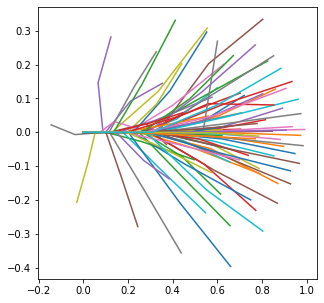

In [63]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
for p in patterns[:, :, :]:
    axs.plot(p[0, :], p[1, :])

## Learn HMM model

In [14]:
segment_length = 4
num_segment = 6
clustering = KMeansOutcome.load_from_file(f"./pretrained/hmm_segment_clustering_{dataset_suffix}.pickle")
assert clustering.segment_length == segment_length
traj_length = num_segment * (segment_length - 1) + 1

with open(f"./data/train_{dataset_suffix}.pickle", "rb") as _file:
    traj_dataset = pickle.load(_file)
trajlets_for_hmm_learning = traj_dataset.get_trajlets(
    length= traj_length * 0.4, overlap=4, to_numpy=True
)
print(trajlets_for_hmm_learning.shape)

(804, 19, 5)


In [15]:
# print(trajlets_for_hmm_learning[0, 0:12, 0:4])
# print(trajlets_for_hmm_learning[0, 0:12, 0:4].reshape([3, 4, 4]))

In [16]:
observations = []
for t in trajlets_for_hmm_learning:
    segments = segmentize_trajectory(t, segment_length)
    obs = clustering.classify_batch(segments)
    observations.append(obs)

In [17]:
# observations

In [18]:
state_dim = 60
hmm = HMMMultinomialFirstOrder(state_dim, clustering.N, verbose=True, max_iters=50)
try:
    hmm.load_from_file(f"./pretrained/hmm_model_param_{dataset_suffix}.pickle")
except Exception as e:
    print("Fail to load parameters. Maybe they do not exist yet.")
    print(e)
hmm.estimate_parameters(np.array(observations))
hmm.save_to_file(f"./pretrained/hmm_model_param_{dataset_suffix}.pickle")

Fail to load parameters. Maybe they do not exist yet.
[Errno 2] No such file or directory: '/Users/linfeng/workspace/courses/nus-cs5340uncertainty/nus-cs5340/notebooks/pretrained/hmm_model_param_4.pickle'
Estimating HMM model parameters...
Iter 1, log-likelihood loss: -26.370041612820796, delta: inf
Iter 2, log-likelihood loss: -24.799149660796402, delta: 1.5708919520243931
Iter 3, log-likelihood loss: -24.774258218004544, delta: 0.02489144279185851
Iter 4, log-likelihood loss: -24.746710632460324, delta: 0.027547585544219544
Iter 5, log-likelihood loss: -24.711166285323834, delta: 0.03554434713649002
Iter 6, log-likelihood loss: -24.657725215989025, delta: 0.0534410693348093
Iter 7, log-likelihood loss: -24.566005770290854, delta: 0.09171944569817114
Iter 8, log-likelihood loss: -24.400199355364684, delta: 0.16580641492616977
Iter 9, log-likelihood loss: -24.128534026802477, delta: 0.27166532856220726
Iter 10, log-likelihood loss: -23.78167150759502, delta: 0.3468625192074555
Iter 11,

## Deploy the learned model

### Predict

In [2]:
clustering = KMeansOutcome.load_from_file(f"./pretrained/hmm_segment_clustering_{dataset_suffix}.pickle")
state_dim = 60
hmm = HMMMultinomialFirstOrder(state_dim, clustering.N, verbose=True, max_iters=3)
hmm.load_from_file(f"./pretrained/hmm_model_param_{dataset_suffix}.pickle")

segment_length = 4
num_segment = 5
num_history_segment = 2
num_future_segment = num_segment - num_history_segment
predictor = HMMLatentSegmentsPredictor(hmm, clustering, N_future_segment=num_future_segment)

In [3]:
traj_length = num_segment * (segment_length - 1) + 1
history_traj_length = num_history_segment * (segment_length - 1) + 1
future_traj_length = num_future_segment * (segment_length - 1) + 1
with open(f"./data/test_{dataset_suffix}.pickle", "rb") as _file:
    traj_dataset = pickle.load(_file)
trajlets_for_testing = traj_dataset.get_trajlets(
    length=traj_length * 0.4,
    overlap=1,
    to_numpy=True
)
print(trajlets_for_testing.shape)

(586, 16, 5)


In [4]:
traj = trajlets_for_testing[10]
print(traj[:, 0:2])
predicted = predictor.predict(traj[0:history_traj_length, :])
print(predicted)

[[ 2.5370557  -3.1497705 ]
 [ 2.5637103  -2.9947375 ]
 [ 2.5040813  -2.750486  ]
 [ 2.4443952  -2.5060007 ]
 [ 2.4753811  -2.2725877 ]
 [ 2.5606513  -2.0462931 ]
 [ 2.570254   -1.8698847 ]
 [ 2.4925604  -1.6228967 ]
 [ 2.4478218  -1.4392515 ]
 [ 2.4777159  -1.2260826 ]
 [ 2.5256832  -1.0155945 ]
 [ 2.5821164  -0.648924  ]
 [ 2.5672405  -0.58770034]
 [ 2.5417454  -0.38699618]
 [ 2.4992167  -0.1640318 ]
 [ 2.5056243  -0.0467331 ]]
[[ 2.570254   -1.8698847 ]
 [ 2.57300642 -1.81932082]
 [ 2.63017269 -1.86480189]
 [ 2.70022837 -1.91959987]
 [ 2.74011442 -1.95079898]
 [ 2.67009943 -1.9716415 ]
 [ 2.58506697 -1.99772021]
 [ 2.53665393 -2.01256807]
 [ 2.5596392  -1.94322698]
 [ 2.58692669 -1.85857469]]


In [22]:
# predicted_center_idx = clustering.classify(predicted)
# print(predicted_center_idx)

In [23]:
# center = np.array(clustering._centers[predicted_center_idx]).reshape([2, -1]).T
# print(center)
# fig, axs = plt.subplots(1, 1, figsize=(10, 10))
# axs.plot(traj[:, 0] - traj[0, 0], traj[:, 1] - traj[0, 1])
# axs.plot(center[:, 0], center[:, 1])

### Evaluation of point estimate error

In [5]:
evaluator = DistanceErrorEvaluator(N_future=future_traj_length, N_history=history_traj_length)

In [6]:
result = evaluator.evaluate(predictor, trajlets_for_testing)
print(result)

{'fde': array([1.50532189, 1.43342917, 0.19616604, 1.12912444, 0.28282705,
       0.86404071, 1.92253892, 1.1542284 , 0.91300264, 0.84770787,
       1.81366481, 0.13136567, 0.42866023, 1.28571405, 0.42671991,
       0.64813434, 0.51711688, 4.93927884, 0.57078855, 2.1131248 ,
       0.18388222, 1.29196311, 0.61043529, 0.28074289, 0.0843343 ,
       1.16579515, 1.40411121, 0.87039853, 0.71318496, 1.37888792,
       1.84130542, 2.62913234, 0.47425958, 2.29301923, 0.51885981,
       0.12100585, 2.15437299, 0.27804565, 0.30629686, 0.28163407,
       0.57902202, 0.98807301, 1.4947689 , 1.02330914, 0.095673  ,
       0.96813991, 1.48391645, 0.97673946, 2.1775942 , 1.34186239,
       0.75449958, 1.24823265, 0.24250782, 1.39314348, 1.34284198,
       0.64412458, 0.46828447, 0.91322526, 0.31018535, 0.4904341 ,
       0.41107651, 0.58020453, 0.3895873 , 1.74338442, 3.36203248,
       1.50804173, 2.81937294, 0.25172554, 0.59501388, 0.73387172,
       2.372509  , 0.22419478, 0.77350106, 1.09402034,

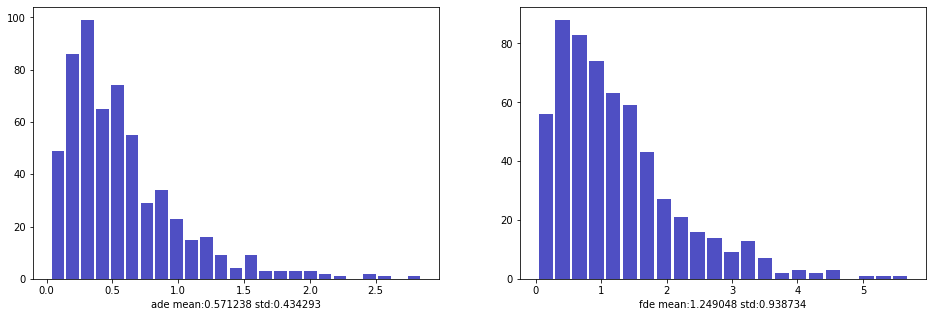

In [7]:
evaluator.hist()

### Evaluation for uncertainty

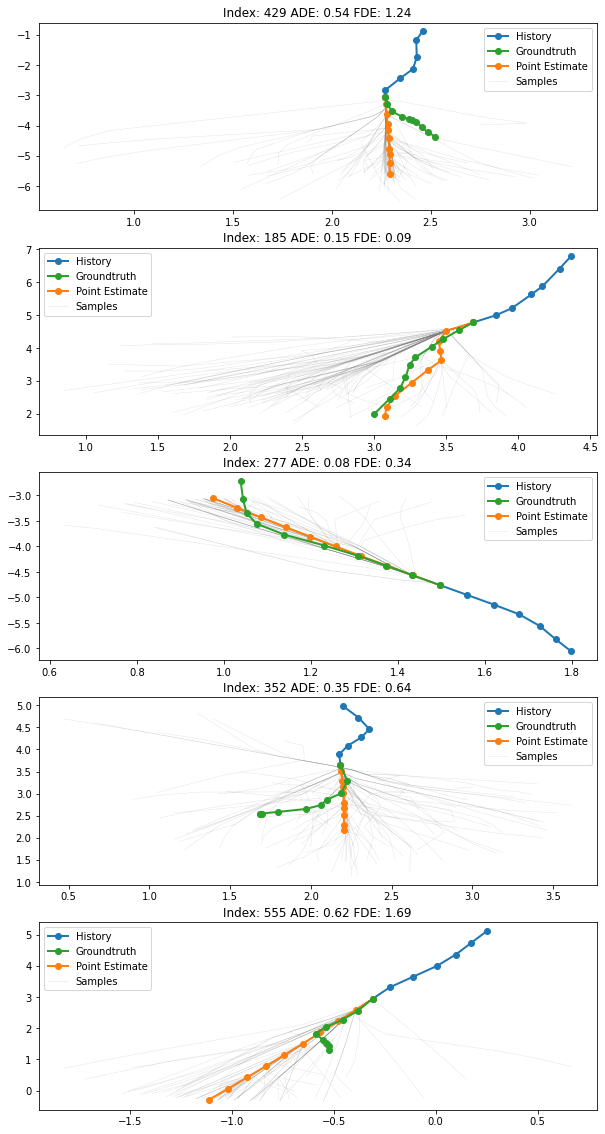

In [47]:
import matplotlib.pyplot as plt

viz = SamplingVisualizer(N_history=history_traj_length, sample_size=100)
fig, axs = plt.subplots(5, 1, figsize=(10, 20))

for ax in axs:
    idx = np.random.randint(0, trajlets_for_testing.shape[0])
    traj = trajlets_for_testing[idx, :, :]
    viz.visualize_to_axis(ax, predictor, traj)
    ax.set_title(f"Index: {idx} ADE: {result['ade'][idx]:.2f} FDE: {result['fde'][idx]:.2f}")
#     ax.set_aspect(1)

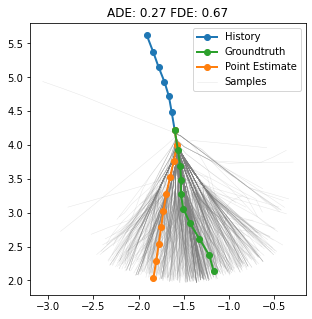

In [23]:
viz = SamplingVisualizer(N_history=history_traj_length, sample_size=1000)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

idx = 407
traj = trajlets_for_testing[idx, :, :]
viz.visualize_to_axis(ax, predictor, traj)
ax.set_title(f"ADE: {result['ade'][idx]:.2f} FDE: {result['fde'][idx]:.2f}")
ax.set_aspect(0.75)

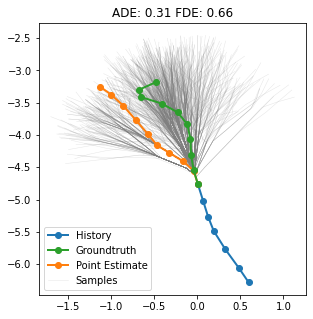

In [55]:
viz = SamplingVisualizer(N_history=history_traj_length, sample_size=1000)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

idx = 224
traj = trajlets_for_testing[idx, :, :]
viz.visualize_to_axis(ax, predictor, traj)
ax.set_title(f"ADE: {result['ade'][idx]:.2f} FDE: {result['fde'][idx]:.2f}")
ax.set_aspect(0.75)

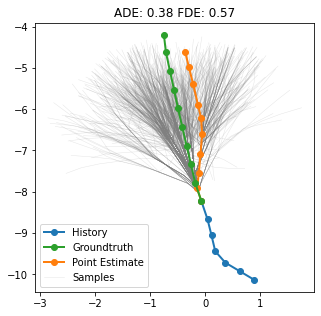

In [42]:
viz = SamplingVisualizer(N_history=history_traj_length, sample_size=1000)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

idx = 501
traj = trajlets_for_testing[idx, :, :]
viz.visualize_to_axis(ax, predictor, traj)
ax.set_title(f"ADE: {result['ade'][idx]:.2f} FDE: {result['fde'][idx]:.2f}")
ax.set_aspect(0.75)

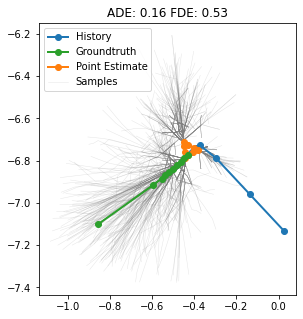

In [33]:
viz = SamplingVisualizer(N_history=history_traj_length, sample_size=1000)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

idx = 579
traj = trajlets_for_testing[idx, :, :]
viz.visualize_to_axis(ax, predictor, traj)
ax.set_title(f"ADE: {result['ade'][idx]:.2f} FDE: {result['fde'][idx]:.2f}")
ax.set_aspect(1)

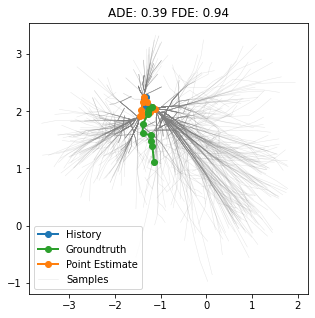

In [36]:
viz = SamplingVisualizer(N_history=history_traj_length, sample_size=1000)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

idx = 313
traj = trajlets_for_testing[idx, :, :]
viz.visualize_to_axis(ax, predictor, traj)
ax.set_title(f"ADE: {result['ade'][idx]:.2f} FDE: {result['fde'][idx]:.2f}")
ax.set_aspect(1.25)

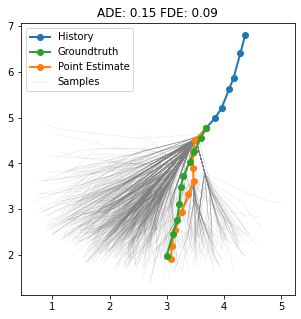

In [54]:
viz = SamplingVisualizer(N_history=history_traj_length, sample_size=1000)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

idx = 185
traj = trajlets_for_testing[idx, :, :]
viz.visualize_to_axis(ax, predictor, traj)
ax.set_title(f"ADE: {result['ade'][idx]:.2f} FDE: {result['fde'][idx]:.2f}")
ax.set_aspect(0.8)